# AugKey Demo
A demonstration of image and keypoint augmentation.

## Install

Along with augkey, the following dependencies should be installed to run this notebook
```
pip install scikit-image matplotlib pycocotools wget
```

In [1]:
%matplotlib inline
import augkey
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import wget
import zipfile
import os

from pycocotools.coco import COCO
from PIL import Image

## Getting the Data
Download and load the COCO data

In [2]:
def download():
    if os.path.exists('annotations_trainval2017'):
        return
    
    wget.download('http://images.cocodataset.org/annotations/annotations_trainval2017.zip')
    with zipfile.ZipFile('annotations_trainval2017.zip', 'r') as zip_ref:
        zip_ref.extractall('annotations_trainval2017')
        
download()

Load an image 

In [3]:
# Load the dataset
coco=COCO('annotations_trainval2017/annotations/person_keypoints_train2017.json')

# Get the image
image_ids = coco.getImgIds()[:1]
image_metas = coco.loadImgs(image_ids)
image_meta = image_metas[0]
image = io.imread(image_meta['coco_url'])

# Get the annotations
annotations_id = coco.getAnnIds(imgIds=[image_meta['id']])
annotations = coco.loadAnns(annotations_id)
bodyparts = np.array(annotations[0]['keypoints']).reshape(-1, 3)
visible = bodyparts[:,2] == 2
visible_bodyparts = bodyparts[visible][:,:2]

loading annotations into memory...
Done (t=5.97s)
creating index...
index created!


## Plot Image

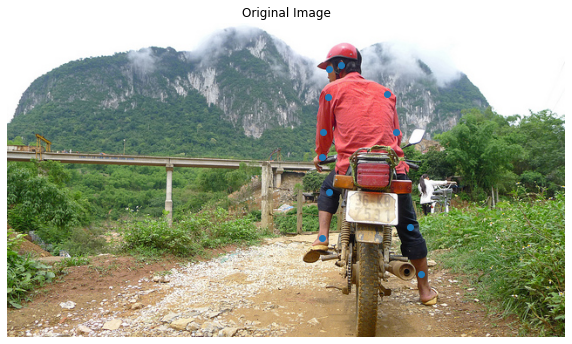

In [4]:
def show_image_with_keypoints(image, keypoints, title):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    x, y = keypoints.T
    plt.scatter(x, y)
    plt.axis('off')
    plt.title(title)
    
show_image_with_keypoints(image, visible_bodyparts, "Original Image")

## Create and Augment Keypoints/Image
We also profile the results and find that the largest bottlenecks are in the image manipulation, which is to be expected

In [5]:
# Create a new RandAug 
randaug = augkey.RandAugment(N=5)

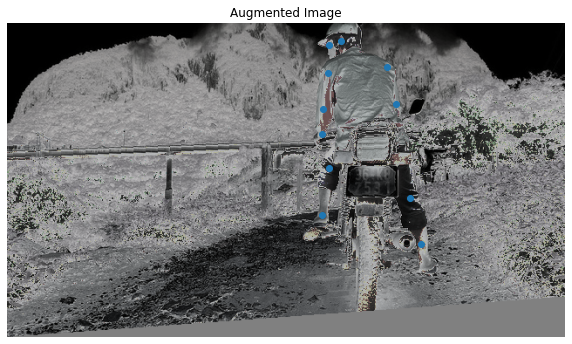

         44926 function calls (44296 primitive calls) in 0.060 seconds

   Ordered by: internal time
   List reduced from 855 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      320    0.006    0.000    0.008    0.000 inspect.py:2926(_bind)
       88    0.005    0.000    0.005    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.003    0.002    0.003    0.002 {built-in method PIL._imaging.blend}
        2    0.002    0.001    0.002    0.001 {method 'point' of 'ImagingCore' objects}
      148    0.001    0.000    0.005    0.000 artist.py:1038(update)

In [6]:
%%prun -s time -l 5

# Get an augmentation plan
plan = randaug.plan_augment() 

# Apply the augmentation plan to the image and keypoints
augmented_image = randaug.apply_image(Image.fromarray(image), *plan)
augmented_keypoints = randaug.apply_keypoints(visible_bodyparts, *plan)

# Clip the keypoints 
show_image_with_keypoints(augmented_image, augmented_keypoints, "Augmented Image")

## Run an Inverse Augmentation on the Keypoints

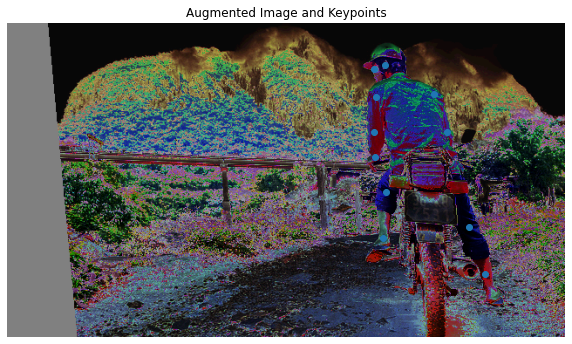

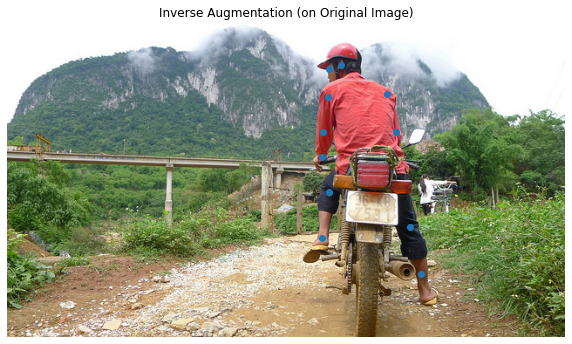

In [31]:
# Get an augmentation plan
plan = randaug.plan_augment() 

# Apply the augmentation plan to the image and keypoints
augmented_image = randaug.apply_image(Image.fromarray(image), *plan)
augmented_keypoints = randaug.apply_keypoints(visible_bodyparts, *plan)

# Show the augmented keypoints
show_image_with_keypoints(augmented_image, augmented_keypoints, "Augmented Image and Keypoints")

# Inverse Augmentation
keypoints = randaug.apply_inv_keypoints(augmented_keypoints, *plan)
show_image_with_keypoints(image, keypoints, "Inverse Augmentation (on Original Image)")